This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation using [tf.keras](https://www.tensorflow.org/programmers_guide/keras) and [eager execution](https://www.tensorflow.org/programmers_guide/eager). 


After training the model in this notebook, you will be able to input a Spanish sentence, such as *"¿todavia estan en casa?"*, and return the English translation: *"are you still at home?"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 mintues to run on a single P100 GPU.

In [1]:
# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf

tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

1.9.0-rc1


In [2]:
## enable eager execution gives out result instantly instead of constructing a computational graph first then run in a session 
x = [[2.]]
m = tf.matmul(x, x)
print(m)

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

Here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [3]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://download.tensorflow.org/data/spa-eng.zip', 
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
path_to_file

2646016/2638744 [==============================] - 0s 0us/step


'/content/.keras/datasets/spa-eng/spa.txt'

In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# unicode_to_ascii("¿todavia estan en casa?")
  
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    w = re.sub(r"([?.!,¿])", r" \1 ", w) ## \1 => like xargs in linux shells, pass on the previous parameter to the next task
    w = re.sub(r'[" "]+', " ", w) ## squeeze the long whitespace to one whitespace
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w
  
preprocess_sentence("¿todavia estan en casa?")

'<start> ¿ todavia estan en casa ? <end>'

In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return word_pairs

In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase.split(' '))
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(path, num_examples):
    # creating cleaned input, output pairs
    pairs = create_dataset(path, num_examples)
    print(pairs[:10])
    
    # index language using the class defined above    
    inp_lang = LanguageIndex(sp for en, sp in pairs)
    targ_lang = LanguageIndex(en for en, sp in pairs)
 
    
    # Vectorize the input and target languages
    
    # Spanish sentences
    input_tensor = [[inp_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]
    print(input_tensor[:10])
    
    # English sentences
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
  
    print(target_tensor[:10])
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [37]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

[['<start> go . <end>', '<start> ve . <end>'], ['<start> go . <end>', '<start> vete . <end>'], ['<start> go . <end>', '<start> vaya . <end>'], ['<start> go . <end>', '<start> vayase . <end>'], ['<start> hi . <end>', '<start> hola . <end>'], ['<start> run ! <end>', '<start> corre ! <end>'], ['<start> run . <end>', '<start> corred . <end>'], ['<start> who ? <end>', '<start> ¿ quien ? <end>'], ['<start> fire ! <end>', '<start> fuego ! <end>'], ['<start> fire ! <end>', '<start> incendio ! <end>']]
[[5, 9090, 3, 4], [5, 9204, 3, 4], [5, 9082, 3, 4], [5, 9089, 3, 4], [5, 4702, 3, 4], [5, 2299, 1, 4], [5, 2304, 3, 4], [5, 9413, 7433, 6, 4], [5, 4270, 1, 4], [5, 4881, 1, 4]]
[[5, 1857, 3, 4], [5, 1857, 3, 4], [5, 1857, 3, 4], [5, 1857, 3, 4], [5, 2058, 3, 4], [5, 3655, 1, 4], [5, 3655, 3, 4], [5, 4815, 6, 4], [5, 1636, 1, 4], [5, 1636, 1, 4]]


In [9]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [47]:
max_length_inp, max_length_targ

(16, 11)

### Create a tf.data dataset

In [0]:
# ## tf.data.Dataset
# from tensorflow.data import Dataset
# import itertools

# def gen():
#   for i in itertools.count(1):
#     yield (i, [1] * i)

# ds = Dataset.from_generator(
#     gen, (tf.int64, tf.int64), (tf.TensorShape([]), tf.TensorShape([None])))
# value = ds.make_one_shot_iterator().get_next()

# print(value)

# filenames = ["/var/data/file1.txt", "/var/data/file2.txt", ...]
# dataset = (Dataset.from_tensor_slices(filenames)
#            .interleave(lambda x:
#                TextLineDataset(x).map(parse_fn, num_parallel_calls=1),
#                cycle_length=4, block_length=16))

In [33]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(BATCH_SIZE))

i=5
for (batch, (input_, target)) in enumerate(dataset):
  if i>0:
    print(batch)
    print(input_)
    print(target)
  i -= 1

0
tf.Tensor(
[[   5 2541 5498 ...    0    0    0]
 [   5 8099 5498 ...    0    0    0]
 [   5 6211 8099 ...    0    0    0]
 ...
 [   5 4661 4326 ...    0    0    0]
 [   5 5752 3895 ...    0    0    0]
 [   5 5196 6955 ...    0    0    0]], shape=(64, 16), dtype=int32)
tf.Tensor(
[[   5 2173 4827 1244 2832  410    3    4    0    0    0]
 [   5 2173 2420 4798 2173 4729    3    4    0    0    0]
 [   5 2173  641 4282 4043 1823    3    4    0    0    0]
 [   5 2173 4738 3458    7  492    3    4    0    0    0]
 [   5 4712 1705 2675    3    4    0    0    0    0    0]
 [   5 4031 1705 4374 1111    3    4    0    0    0    0]
 [   5 1244 4924 2751  509    6    4    0    0    0    0]
 [   5 2173  641 4720 2899 1563    3    4    0    0    0]
 [   5 4459  368 2876    3    4    0    0    0    0    0]
 [   5 4459 2575  310    3    4    0    0    0    0    0]
 [   5 2173 1172 4282 3762 2071    3    4    0    0    0]
 [   5 4016 3664 3036    3    4    0    0    0    0    0]
 [   5 2173 3525    3 

## Write the encoder and decoder model

Here, we'll implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://www.tensorflow.org/tutorials/seq2seq). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://www.tensorflow.org/tutorials/seq2seq#background_on_the_attention_mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence.

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*. 

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

We're using *Bahdanau attention*. Lets decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU
  
The shapes of all the vectors at each step have been specified in the comments in the code:

In [12]:
tf.test.is_gpu_available()

True

### Glorot uniform initializer, also called Xavier uniform initializer.

- It draws samples from a uniform distribution within [-limit, limit] where limit is $\sqrt{\frac{6}{fan\_in + fan\_out}}$ 
  - __fan_in__ is the number of input units in the weight tensor 
  - __fan_out__ is the number of output units in the weight tensor.

In [0]:
def gru(units):
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, hidden_size)
        score = tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * max_length, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

## Define the optimizer and the loss function

In [0]:
optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
  mask = 1 - np.equal(real, 0) ## if real == 0, then 1 - True = 0; otherwise 1- Flase = 1
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask ## is real is 0 padded, no loss burdened to save computation
  return tf.reduce_mean(loss_)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
  - Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the output from a prior time step as input.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [39]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset):
        # inp shape : (64 x 16)
        # targ shape : (64 x 11)
        loss = 0       
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden) ## execute the 'call' function defined in Class Encoder
            dec_hidden = enc_hidden
            # targ_lang = LanguageIndex(en for en, sp in pairs)
            # initialize the dec_input
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            # targ.shape[1]: words in a sentence
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                # no need to acquire the attention weights
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
               
                # predictions shape == (batch_size * max_length, vocab)
                #        targ shape == (batch_size *     1     , vocab)      
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                # targ shape == (batch_size, 1, vocab)
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        total_loss += (loss / int(targ.shape[1])) # targ.shape[1] = max_length
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
      
        optimizer.apply_gradients(zip(gradients, variables), tf.train.get_or_create_global_step())

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         loss.numpy() / int(targ.shape[1])))
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss/len(input_tensor)))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.0782
Epoch 1 Batch 100 Loss 0.0607
Epoch 1 Batch 200 Loss 0.1216
Epoch 1 Batch 300 Loss 0.1169
Epoch 1 Loss 0.0012
Time taken for 1 epoch 107.04331493377686 sec

Epoch 2 Batch 0 Loss 0.0739
Epoch 2 Batch 100 Loss 0.1151
Epoch 2 Batch 200 Loss 0.1025
Epoch 2 Batch 300 Loss 0.1009
Epoch 2 Loss 0.0011
Time taken for 1 epoch 106.87625813484192 sec

Epoch 3 Batch 0 Loss 0.0712
Epoch 3 Batch 100 Loss 0.0705
Epoch 3 Batch 200 Loss 0.0638
Epoch 3 Batch 300 Loss 0.1077
Epoch 3 Loss 0.0010
Time taken for 1 epoch 106.98916363716125 sec

Epoch 4 Batch 0 Loss 0.0479
Epoch 4 Batch 100 Loss 0.0693
Epoch 4 Batch 200 Loss 0.0545
Epoch 4 Batch 300 Loss 0.0806
Epoch 4 Loss 0.0009
Time taken for 1 epoch 106.92719006538391 sec

Epoch 5 Batch 0 Loss 0.0639
Epoch 5 Batch 100 Loss 0.0671
Epoch 5 Batch 200 Loss 0.0932
Epoch 5 Batch 300 Loss 0.1052
Epoch 5 Loss 0.0009
Time taken for 1 epoch 106.91724753379822 sec

Epoch 6 Batch 0 Loss 0.0995
Epoch 6 Batch 100 Loss 0.0601
Epoch 6 Batch 200

In [40]:
variables

[<tf.Variable 'encoder/embedding/embeddings:0' shape=(9414, 256) dtype=float32, numpy=
 array([[ 0.5125716 ,  0.8245362 ,  0.56031436, ...,  0.08857868,
          0.50070614,  0.37458286],
        [ 1.2462964 ,  0.06821021,  0.47963914, ...,  0.8599553 ,
          0.2994965 ,  0.46479762],
        [ 0.3322044 ,  0.5755392 ,  0.7939083 , ...,  0.41400465,
          0.06411676,  0.12261444],
        ...,
        [ 0.80639356,  0.29617733,  0.8158936 , ...,  0.38865995,
          0.9668266 ,  0.56494653],
        [ 0.834935  ,  0.7107854 , -0.0145288 , ...,  0.60252774,
          0.3062037 ,  0.89033717],
        [ 0.66786337,  0.50030553, -0.15521693, ...,  0.7665484 ,
          0.38173717, -0.06104789]], dtype=float32)>,
 <tf.Variable 'encoder/cu_dnngru/kernel:0' shape=(256, 3072) dtype=float32, numpy=
 array([[ 0.05647275,  0.12643912,  0.0030217 , ..., -0.18959875,
         -0.00176977,  0.00756644],
        [ 0.04771179,  0.11252786,  0.01438036, ..., -0.00821857,
         -0.0284828

In [41]:
gradients

 <tf.Tensor: id=34183942, shape=(256, 3072), dtype=float32, numpy=
 array([[ 1.3320980e-05,  1.1937304e-06,  1.5188846e-05, ...,
         -6.1289077e-03, -6.8325251e-03, -6.7553045e-03],
        [ 7.6430792e-04,  9.2332793e-04,  9.5788017e-04, ...,
         -6.4348206e-03, -6.4439685e-03, -2.2767247e-03],
        [-1.7040879e-04,  2.3813382e-05,  4.1113031e-05, ...,
          2.6975805e-08,  1.2291669e-07, -7.2973826e-08],
        ...,
        [ 5.1773856e-07,  3.6202889e-06,  1.3878347e-06, ...,
         -1.8668642e-03, -3.9470736e-03, -4.9874648e-03],
        [-1.7135552e-04, -1.5373500e-04, -7.4765339e-05, ...,
         -4.9537161e-06,  1.7965385e-06, -4.7396575e-06],
        [-3.3016795e-07, -1.9032890e-07, -3.7650699e-07, ...,
          6.1659439e-04,  8.4192702e-04,  7.3360937e-04]], dtype=float32)>,
 <tf.Tensor: id=34183943, shape=(1024, 3072), dtype=float32, numpy=
 array([[ 9.55782227e-08, -1.21290566e-06, -3.57108178e-07, ...,
         -9.53014750e-11, -2.91123192e-09, -1.067

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [0]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.multinomial(tf.exp(predictions), num_samples=1)[0][0].numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        # teacher forcing 
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    print(attention_plot.shape) # target(len(characters) in translated sentence x (len(characters) in to-be-translated sentence )
    print(attention_plot)    
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

(11, 16)
[[5.58312284e-03 3.19238842e-01 2.92620540e-01 2.70406604e-01
  1.02667466e-01 5.34372125e-03 1.49080064e-03 1.37707661e-03
  2.86965253e-04 1.55349495e-04 1.43802405e-04 1.40846707e-04
  1.38705669e-04 1.36901304e-04 1.35313312e-04 1.33918744e-04]
 [1.07463971e-02 2.40573168e-01 3.06724191e-01 3.52005959e-01
  8.41065720e-02 3.02681583e-03 9.76605574e-04 5.85337461e-04
  2.24998861e-04 1.54785434e-04 1.48407868e-04 1.46651510e-04
  1.45770537e-04 1.45191923e-04 1.44767386e-04 1.44441234e-04]
 [2.17098580e-03 2.86218096e-02 4.33663130e-01 4.18928087e-01
  9.02863592e-02 8.73693265e-03 5.22647053e-03 3.16930842e-03
  1.26969314e-03 1.16498873e-03 1.14088855e-03 1.13118498e-03
  1.12607609e-03 1.12307630e-03 1.12115545e-03 1.11985230e-03]
 [2.37916072e-04 9.98051473e-05 6.32945299e-02 6.20618761e-01
  2.70931542e-01 2.05887929e-02 8.55059363e-03 3.95074859e-03
  1.92358473e-03 1.48238509e-03 1.41531811e-03 1.39263179e-03
  1.38351100e-03 1.37886661e-03 1.37626671e-03 1.37470954e

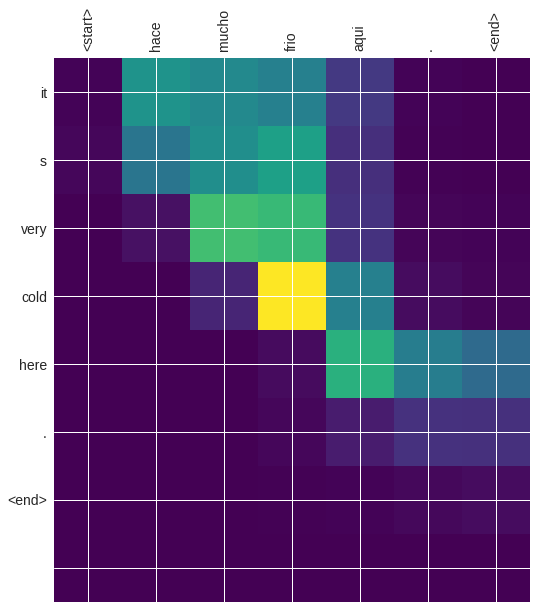

In [46]:
translate('hace mucho frio aqui.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

(11, 16)
[[1.55152977e-02 3.25485170e-01 3.93794268e-01 2.28037611e-01
  2.76244227e-02 4.58976533e-03 2.26523704e-03 6.35365606e-04
  2.76068022e-04 2.48043216e-04 2.49518111e-04 2.52341793e-04
  2.54621584e-04 2.56297877e-04 2.57521315e-04 2.58429762e-04]
 [5.74087538e-03 1.41449273e-01 6.88098073e-01 1.22589380e-01
  3.93056870e-02 1.13384752e-03 5.52284939e-04 2.35922053e-04
  1.18818767e-04 1.12821748e-04 1.11756875e-04 1.11095062e-04
  1.10566798e-04 1.10146451e-04 1.09816589e-04 1.09558205e-04]
 [7.34882057e-03 1.74410604e-02 7.94481412e-02 6.26035452e-01
  2.28567585e-01 1.45413009e-02 7.87315238e-03 4.03741514e-03
  1.85718434e-03 1.82291982e-03 1.83321896e-03 1.83899736e-03
  1.84058805e-03 1.83989294e-03 1.83818559e-03 1.83615158e-03]
 [1.30719959e-03 2.42735623e-04 2.87665962e-03 7.22534135e-02
  5.26438177e-01 1.66301116e-01 8.13084319e-02 2.09003296e-02
  1.63507834e-02 1.59925260e-02 1.59943644e-02 1.60063114e-02
  1.60097312e-02 1.60083883e-02 1.60059296e-02 1.60039160e

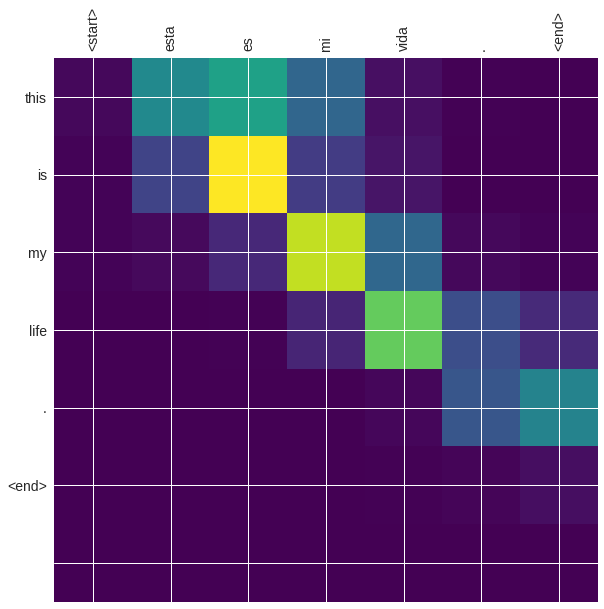

In [48]:
translate('esta es mi vida.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

(11, 16)
[[1.29955038e-01 8.00096616e-03 2.73544073e-01 5.73437214e-01
  5.03838994e-03 8.82216357e-03 4.72213491e-04 2.27544937e-04
  1.41602170e-04 5.85670241e-05 4.99334819e-05 4.94458654e-05
  4.99975285e-05 5.05539865e-05 5.09779493e-05 5.13059458e-05]
 [2.97635281e-03 6.29973970e-03 5.06366909e-01 4.24828768e-01
  2.02696491e-02 3.35562006e-02 2.80654244e-03 8.51094956e-04
  5.00623370e-04 2.60214932e-04 2.25054711e-04 2.15609776e-04
  2.12371524e-04 2.11131206e-04 2.10246435e-04 2.09492762e-04]
 [1.90966239e-03 5.55243576e-04 4.01730329e-01 1.54984996e-01
  1.62028074e-01 1.92806363e-01 4.84111086e-02 1.38632907e-02
  5.55768097e-03 3.12507944e-03 2.56107445e-03 2.51872139e-03
  2.49857712e-03 2.48910813e-03 2.48275069e-03 2.47794553e-03]
 [4.77667869e-04 8.67512790e-05 1.69202294e-02 2.28434633e-02
  3.15720886e-01 3.85828674e-01 1.54080778e-01 3.63365151e-02
  1.59950275e-02 1.02583021e-02 7.53551489e-03 7.00671179e-03
  6.82729436e-03 6.74442528e-03 6.68939110e-03 6.64843246e

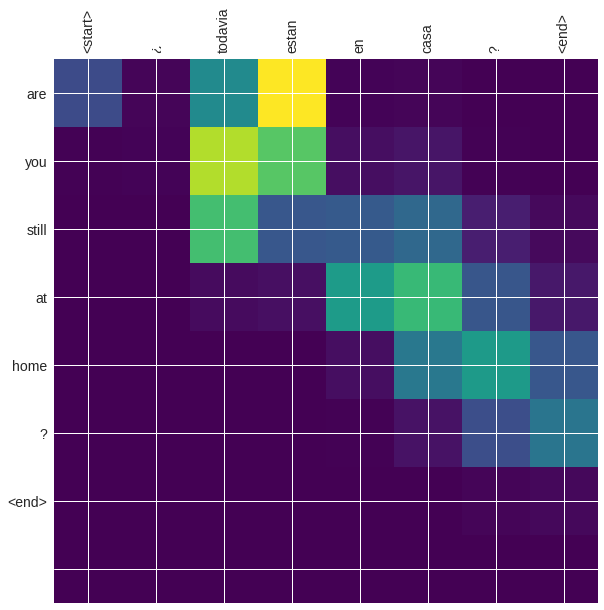

In [49]:
translate('¿todavia estan en casa?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
## here estan: are; todavia: still, the order is reversed, so the attention is not necessary on diagonal spots

(11, 16)
[[4.17562015e-03 8.69649768e-01 5.95332086e-02 6.20932430e-02
  3.45488242e-03 5.36125503e-04 1.22413097e-04 6.03801309e-05
  4.89952981e-05 4.73816108e-05 4.68658727e-05 4.65939411e-05
  4.63931683e-05 4.62143253e-05 4.60432857e-05 4.58766845e-05]
 [1.27266198e-02 1.74117491e-01 1.79170638e-01 6.13668561e-01
  1.74571481e-02 9.52842587e-04 4.17192059e-04 1.79730152e-04
  1.65708188e-04 1.63735793e-04 1.63396660e-04 1.63385921e-04
  1.63420365e-04 1.63427685e-04 1.63393706e-04 1.63321107e-04]
 [1.44714187e-03 2.03767195e-02 6.57028183e-02 4.44737136e-01
  3.18414241e-01 6.32391348e-02 1.34863770e-02 8.11793562e-03
  8.05626344e-03 8.05269182e-03 8.05536192e-03 8.05858802e-03
  8.06134474e-03 8.06345418e-03 8.06494243e-03 8.06590077e-03]
 [2.55209015e-04 3.11602629e-03 3.73076112e-03 1.52846962e-01
  4.86671925e-01 1.81087673e-01 3.56448479e-02 1.62348468e-02
  1.52233569e-02 1.51226874e-02 1.50902728e-02 1.50605878e-02
  1.50285130e-02 1.49950739e-02 1.49617381e-02 1.49295395e

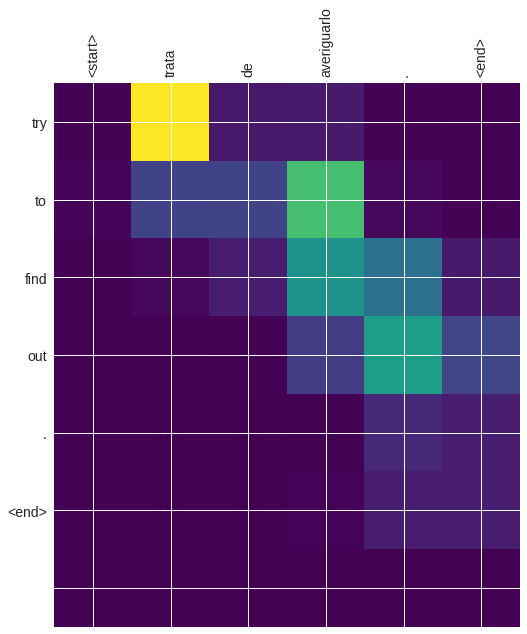

In [50]:
# wrong translation
translate('trata de averiguarlo.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)